In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [7]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.mllib.evaluation import RegressionMetrics
import sys
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql.functions import when
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("Jena_Climate").getOrCreate()

In [8]:
#load data
def load_data():
    df=spark.read.option("header", "true").csv("jena_climate_2009_2016.csv")
    return df

#Use MinMaxScaler to get data between 0 and 1
def preprocess_data(df):
    #consider temperature as feature to predict weather
    df_ftrs=df.select(['T (degC)'])
    #normalize data
    vector_asblr = VectorAssembler(inputCols=df_ftrs.columns, outputCol="x")
    norm_scalar = MinMaxScaler(inputCol="x", outputCol="y")
    pipe_line = Pipeline(stages=[vector_asblr, norm_scalar])
    scale_model = pipe_line.fit(df_ftrs)
    scale_features = scale_model.transform(df_ftrs)

    #separate feature columns
    scale_features = scale_features.select(create_lst_from_arr(F.col("y")).alias("split_ftrs")).select([F.col("split_ftrs")[f].alias("T_Scaled") for f in range(len(df_ftrs.columns))])

    return scale_features

# split array
def create_lst_from_arr(colum):
    def create_lst(vec):
        return vec.toArray().tolist()
    return F.udf(create_lst, ArrayType(DoubleType()))(colum)

#Prepare data based on time sequence
def LSTM_data(data, time_sequence = 1):
    return_X, return_Y = [], []
    z=0
    while z <len(data)-time_sequence-1:
        return_X.append(data[z:(z+time_sequence)])
        return_Y.append(data[z + time_sequence])
        z+=1
    return np.array(return_X), np.array(return_Y)


#Split data - 65% train data, 20% validation data, 15% test data
def train_test_split(attributes, time_sequence):
    attributes = attributes.toPandas()
    attributes['attributes'] = attributes.values.tolist()
    attributes = attributes['attributes'].tolist()
    total_smps = len(attributes)
    trn_smp_sz=int(total_smps*0.65)
    val_smp_sz=int(total_smps*0.85)

    trn_dt, val_dt, tst_dt =attributes[0:trn_smp_sz],attributes[trn_smp_sz:val_smp_sz],attributes[val_smp_sz:total_smps]

    trnx, trny = LSTM_data(trn_dt, time_sequence)
    valx, valy = LSTM_data(val_dt, time_sequence)
    tstx, tsty = LSTM_data(tst_dt, time_sequence)

    return trnx, trny, valx, valy, tstx, tsty

In [9]:
def train_model(trainx, trainy):
    lstm_md=Sequential()
    lstm_md.add(LSTM(25,return_sequences=True,input_shape=(trainx.shape[1],trainx.shape[2])))
    lstm_md.add(LSTM(25,return_sequences=True))
    lstm_md.add(LSTM(25,return_sequences=True))
    lstm_md.add(LSTM(25))
    lstm_md.add(Dense(1))
    lstm_md.compile(loss='mean_squared_error',optimizer='adam')

    return lstm_md

In [ ]:

if __name__ == "__main__":

    #load and preprocess data
    data = load_data()

    print("-----Weather Data-----")
    data.show()
    print("-----Weather Data Schema-----")
    data.printSchema()

    data = data.withColumn("p (mbar)", when(col("p (mbar)") == "", None).otherwise(col("p (mbar)").cast("double")))
    data = data.withColumn("T (degC)", when(col("T (degC)") == "", None).otherwise(col("T (degC)").cast("double")))
    data = data.withColumn("VPmax (mbar)", when(col("VPmax (mbar)") == "", None).otherwise(col("VPmax (mbar)").cast("double")))
    data = data.withColumn("VPdef (mbar)", when(col("VPdef (mbar)") == "", None).otherwise(col("VPdef (mbar)").cast("double")))
    data = data.withColumn("sh (g/kg)", when(col("sh (g/kg)") == "", None).otherwise(col("sh (g/kg)").cast("double")))
    data = data.withColumn("rho (g/m**3)", when(col("rho (g/m**3)") == "", None).otherwise(col("rho (g/m**3)").cast("double")))
    data = data.withColumn("wv (m/s)", when(col("wv (m/s)") == "", None).otherwise(col("wv (m/s)").cast("double")))

    # Check the schema again and proceed with further analysis
    print("-----Processed Weather Data Schema-----")
    data.printSchema()
    preprcs_dt = preprocess_data(data)

    print("----Processed Data-----")
    preprcs_dt.show()

    #hyper-parameters
    epochs = [25,50]
    time_sequence = [1,5,10]
    batch_size = [100]


    for steps in time_sequence:
        for iter in epochs:
            for b in batch_size:
                print("----***----Training LSTM with time sequence : {}, # of iterations: {}, batch size : {}".format(steps,iter,b))

                #split data into train, val and test
                trnx, trny, valx, valy, tstx, tsty = train_test_split(preprcs_dt, steps)

                #train multi layer lstm model
                model = train_model(trnx, trny)
                model.fit(trnx,trny,validation_data=(valx,valy),epochs=iter,batch_size=b,verbose=1)
                train_pred = model.predict(trnx)

                #test multi layer lstm model
                test_pred = model.predict(tstx)

                #To evaluate, convert into proper format
                pred_train = train_pred.flatten().tolist()
                pred_test = test_pred.flatten().tolist()

                actual_train = trny.flatten().tolist()
                actual_test = tsty.flatten().tolist()

                train = spark.createDataFrame(zip(actual_train, pred_train), ['actual_output', 'predicted_output'])
                test = spark.createDataFrame(zip(actual_test, pred_test), ['actual_output', 'predicted_output'])

                train_values = train.rdd.map(tuple)
                test_values = test.rdd.map(tuple)


                #Performance evaluation of the model
                print("\n\n----Training Evaluation----")
                performance = RegressionMetrics(train_values)

                print("MSE: {}".format(performance.meanSquaredError))
                print("RMSE: {}".format(performance.rootMeanSquaredError))
                print("MAE: {}".format(performance.meanAbsoluteError))


                print("\n\n----Testing Evaluation----")
                performance = RegressionMetrics(test_values)

                print("MSE: {}".format(performance.meanSquaredError))
                print("RMSE: {}".format(performance.rootMeanSquaredError))
                print("MAE: {}\n\n".format(performance.meanAbsoluteError))



-----Weather Data-----
+-------------------+--------+--------+--------+-----------+------+------------+------------+------------+---------+---------------+------------+--------+-------------+--------+
|          Date Time|p (mbar)|T (degC)|Tpot (K)|Tdew (degC)|rh (%)|VPmax (mbar)|VPact (mbar)|VPdef (mbar)|sh (g/kg)|H2OC (mmol/mol)|rho (g/m**3)|wv (m/s)|max. wv (m/s)|wd (deg)|
+-------------------+--------+--------+--------+-----------+------+------------+------------+------------+---------+---------------+------------+--------+-------------+--------+
|01.01.2009 00:10:00|  996.52|   -8.02|  265.40|      -8.90| 93.30|        3.33|        3.11|        0.22|     1.94|           3.12|     1307.75|    1.03|         1.75|  152.30|
|01.01.2009 00:20:00|  996.57|   -8.41|  265.01|      -9.28| 93.40|        3.23|        3.02|        0.21|     1.89|           3.03|     1309.80|    0.72|         1.50|  136.10|
|01.01.2009 00:30:00|  996.53|   -8.51|  264.91|      -9.31| 93.90|        3.21|       

In [ ]:
#actual output vs predicted output plot
plt.title('Multi-Layer LSTM')
plt.scatter(actual_test,pred_test)
plt.xlabel('Actual Output')
plt.ylabel('Predicted Output')
plt.legend(['Weather Data'])

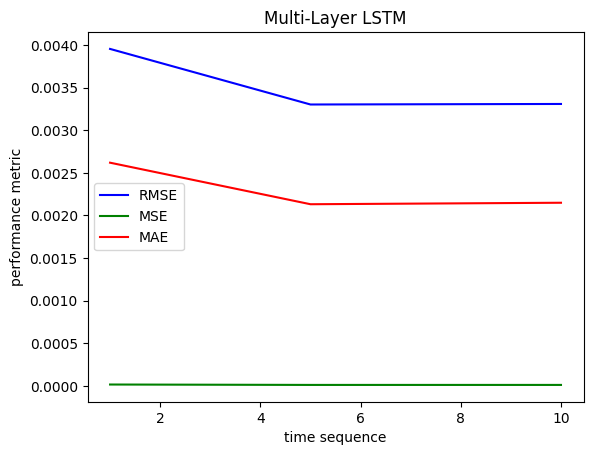

In [ ]:
# performance metric (RMSE,MSE,MAE) vs time sequence plot
time=[1,5,10]
mse=[1.5645494926336845e-05,1.0909691167101974e-05,1.0951009527245045e-05]
rmse=[0.003955438651570373,0.0033029821626981235,0.0033092309570722086]
mae=[0.002619818718823403,0.0021321340959928174,0.0021496003647497246]
plt.title('Multi-Layer LSTM')
plt.plot(time,rmse,label='RMSE',color='b')
plt.plot(time,mse,label='MSE',color='g')
plt.plot(time,mae,label='MAE',color='r')
plt.xlabel('time sequence')
plt.ylabel('performance metric')
plt.legend()